In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and pre-processing the dataset

In [3]:
(X_train, y_train), (X_test, y_test)  = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
X_train.shape,y_train.shape, type(X_train),type(y_train)

((60000, 28, 28), (60000,), numpy.ndarray, numpy.ndarray)

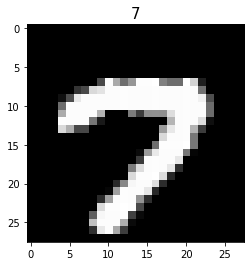

In [5]:
i = np.random.randint(0,60000)
plt.imshow(X_train[i], cmap = "gray")
plt.title(y_train[i], fontsize = 15)
plt.show()

In [6]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_train.shape

(60000, 28, 28, 1)

In [7]:
# X_train = X_train / 255

X_train = (X_train - 127.5) / 127.5
X_train.max(),X_train.min()

(1.0, -1.0)

In [8]:
buffer_size = 60000
batch_size = 256

In [9]:
buffer_size / batch_size

234.375

In [10]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [11]:
# 235 tane 256 lık var !!!
i = 0
for _ in X_train:
  
    i+=1

print(i)

235


In [12]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float64>

# Building the generator
- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/

- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [13]:
7*7*256

12544

In [14]:
def build_generator():

    network = tf.keras.models.Sequential()

    network.add(tf.keras.layers.Dense(7*7*256, use_bias = False, input_shape = (100, )))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())

    network.add(tf.keras.layers.Reshape((7,7,256)))

    # 7x7x128
    network.add(tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = "same", use_bias = False))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())

    # 14x14x64
    network.add(tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (5,5),strides = (2,2), padding = "same", use_bias = False))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())

    # 28x28x1
    network.add(tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))    

    network.summary()

    return network

In [15]:
generator = build_generator() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [16]:
noise = tf.random.normal([1,100])
np.array(noise).max(),np.array(noise).min()

(2.2030451, -2.2395558)

In [17]:
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 28, 28, 1])

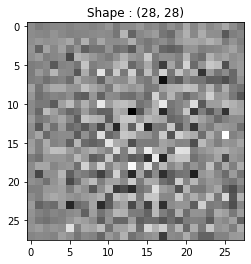

In [18]:
plt.imshow(generated_image[0,:,:,0], cmap = "gray")
plt.title("Shape : {}".format(np.array(generated_image[0,:,:,0]).shape))
plt.show()

# Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [19]:
def build_discriminator():

    network = tf.keras.models.Sequential()

    # 14x14x64
    network.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), strides = (2,2), padding ="same", input_shape = [28,28,1]))
    network.add(tf.keras.layers.LeakyReLU())
    network.add(tf.keras.layers.Dropout(rate = 0.3))

    # 7x7x128
    network.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding ="same"))
    network.add(tf.keras.layers.LeakyReLU())
    network.add(tf.keras.layers.Dropout(rate = 0.3))

    network.add(tf.keras.layers.Flatten())
    network.add(tf.keras.layers.Dense(units = 1))

    network.summary()

    return network

In [20]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [21]:
discriminator(generated_image, training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00073132]], dtype=float32)>

# Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [22]:
cross_entorpy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [23]:
cross_entorpy([1.,1.],[2.,2.])

<tf.Tensor: shape=(), dtype=float32, numpy=0.12692802>

In [24]:
def discriminator_loss(expected_output, fake_output):

    real_loss = cross_entorpy(tf.ones_like(expected_output),expected_output)
    fake_loss = cross_entorpy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

In [25]:
def generator_loss(fake_output):

    return cross_entorpy(tf.ones_like(fake_output),fake_output)

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Traning The Model

In [27]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16
batch_size = 256

@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size , noise_dim])

    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:

        generated_image = generator(noise, training = True)

        expected_output = discriminator(images,training = True)
        fake_output = discriminator(generated_image, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])
test_images.shape

TensorShape([16, 100])

In [29]:
def train(dataset, epochs , test_images):

    for epoch in range(epochs + 1):
        for image_batch in dataset:

            #print(image_batchs.shape)
            train_steps(image_batch)

        print("Epoch : ", epoch)
        generated_images = generator(test_images, training = False)
        fig = plt.figure(figsize = (10,10))
        
        for i in range(generated_images.shape[0]):

            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap = "gray")
            plt.axis("off")

        plt.show()

In [ ]:
train(X_train, epochs , test_images)

# HomeWork and Summary

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

In [32]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [33]:
X_train.shape

(60000, 28, 28)

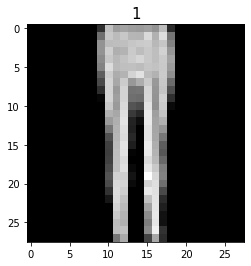

In [34]:
i = np.random.randint(0,60000)
plt.imshow(X_train[i],cmap = "gray")
plt.title(f"{y_train[i]}", fontsize = 15)
plt.show()

In [35]:
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype("float32")
X_train = (X_train - 127.5) / 127.5
X_train.shape,X_train.max(),X_train.min()

((60000, 28, 28, 1), 1.0, -1.0)

In [37]:
buffer_size = 60000
batch_size = 256

X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
# (X_train, y_train), (_ , _) = tf.keras.datasets.fashion_mnist.load_data()

#buffer_size = 60000
#batch_size = 256

#X_train = X_train.reshape(X_train.shape[0], 28 , 28, 1).astype("float32")
#X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

###### Building Generator 

def build_generator():

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units = 7*7*256, use_bias = False, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7,7,256)))

    model.add(tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (5,5),strides = (1,1), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))

    return model

####### Build Discriminator

def build_discriminator():

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", input_shape = [28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate = 0.3))

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding = "same", input_shape = [28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate = 0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 1))

    return model

#####

generator = build_generator()
discriminator = build_discriminator()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

#####

##### Calculate The Loss

def discriminator_loss(expected_loss, fake_output):

    real_loss = cross_entropy(tf.ones_like(expected_loss),expected_loss)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)

    total_loss = fake_loss + real_loss

    return total_loss

def generator_loss(fake_output):

    return cross_entropy(tf.ones_like(fake_output),fake_output)


#####

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-04)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-04)

#####

####### Traning The Model

epochs = 50
noise_dim = 100
num_images_to_generate = 16

# buffer_size = 60000
# batch_size = 256

@tf.function
def train_steps(images):

    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape : 

        generated_image = generator(noise, training = True)

        expected_output = discriminator(images, training = True)
        fake_output = discriminator(generated_image, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_dicsriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_dicsriminator, discriminator.trainable_variables))

test_images = tf.random.normal([num_images_to_generate, noise_dim])

def train(dataset,epochs , test_images):

    for epoch in range(epochs + 1):

        for image_batch in dataset:
            train_steps(image_batch)

        print("Epoch", epoch)

        predictions = generator(test_images, training = False)
        fig = plt.figure(figsize = (10,10))

        for i in range(predictions.shape[0]):

            plt.subplot(4,4,i+1)
            plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap = "gray")
            plt.axis("off")

        plt.show()

train(X_train , epochs, test_images)